# Process data using multiple workflows

## Import packages

In [1]:
%matplotlib inline
import os
import shutil
import cv2
import craft_wrapper
import numpy as np
from utils import *
from lxml import etree
from matplotlib import pyplot as plt

In [2]:
## Set pyplot figure size
plt.rcParams['figure.figsize'] = [20, 20]

## Setup paths

In [3]:
PATH_TO_IMAGE_FOLDER = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\images'  # Path to original images
PATH_TO_ORIGINAL_ANNOTATIONS = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\original_annotations'  # Path to original annotations (converted to individual files)
PATH_TO_DESTINATION_ANNOTATIONS = r'C:\Users\starc\PycharmProjects\TableBank-Recognition-Processing\annotations'  # Path to save new XML annotations

In [4]:
image_name = r'SM08-Harris-Street-Village-FES-2012_7'
image_path = os.path.join(PATH_TO_IMAGE_FOLDER, image_name + '.png')
original_annotation_path = os.path.join(PATH_TO_ORIGINAL_ANNOTATIONS, image_name + '.xml')
destination_annotation_path = os.path.join(PATH_TO_DESTINATION_ANNOTATIONS, image_name + '.xml')

## Load image

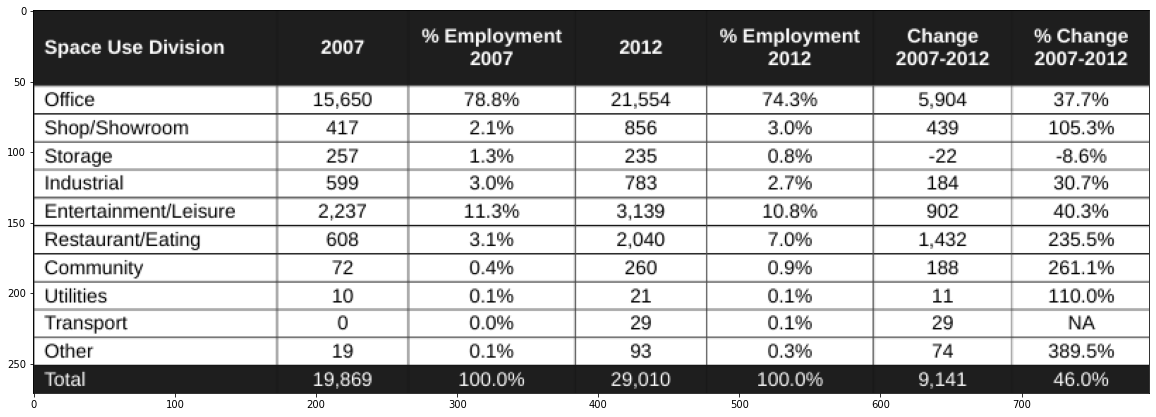

In [5]:
img = cv2.imread(image_path, 0)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
plt.imshow(img)
plt.show()

## OCR using CRAFT

### Initialize CRAFT

In [6]:
CRAFT = craft_wrapper.CRAFT_pytorch()

Loading weights from checkpoint (craft_mlt_25k.pth)


### Detect text

In [7]:
bboxes, polys, heatmap = CRAFT.detect_text(img)

### Clean bounding boxes and show result

In [8]:
cleaned_bboxes = []
for i, box in enumerate(bboxes):
    poly = np.array(box).astype(np.int32).reshape((-1))
    min_x = int(min(poly[0], poly[6]))
    max_x = int(max(poly[2], poly[4]))
    min_y = int(min(poly[1], poly[3]))
    max_y = int(max(poly[5], poly[7]))
    cleaned_bboxes.append([min_x, min_y, max_x, max_y])

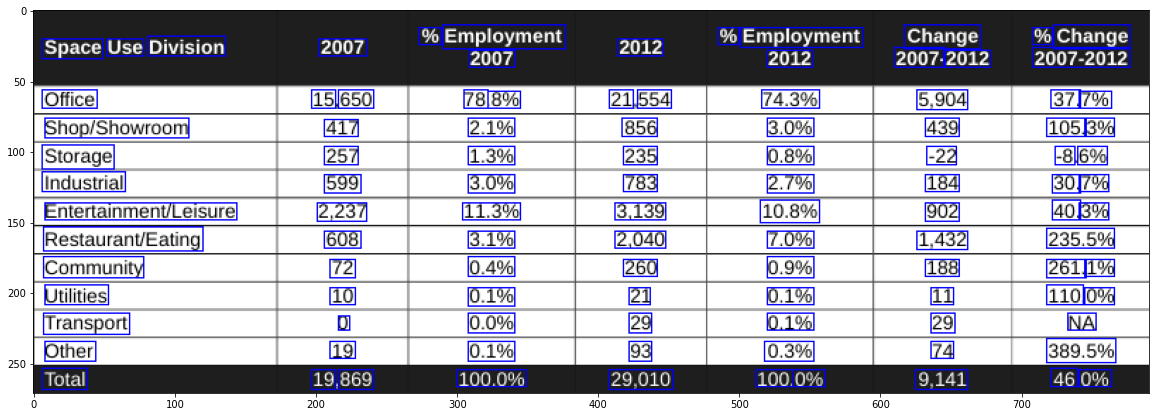

In [9]:
def show_bounding_boxes(img, _bboxes):
    img = np.array(img)
    for bbox in _bboxes:
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 1)

    return img
result = show_bounding_boxes(img, cleaned_bboxes)
plt.imshow(result)

## Merge near bounding boxes

### Check for intersecting bounding boxes (horizontal)

In [10]:
def check_horizontal_line(img_segment_mid, background_pixel_value):
    mid_pixel_values = np.unique(img_segment_mid)
    if len(mid_pixel_values) == 1:
        if mid_pixel_values[0] != background_pixel_value:
            return True  # Have only pixel value that different from background => Has line
    else:
        full_line = False
        for line in img_segment_mid:
            values, counts = np.unique(line, return_counts=True)
            sum_other_than_background_pixel = 0
            sum_background_pixel = 0
            for i in range(len(values)):
                if values[i] != background_pixel_value:
                    sum_other_than_background_pixel += counts[i]
                else:
                    sum_background_pixel += counts[i]
            if sum_background_pixel / 4 < sum_other_than_background_pixel:
                full_line = True
                break
        if full_line:
            return True
        return False

for bbox1 in cleaned_bboxes:
    for bbox2 in cleaned_bboxes:
        if bbox1 is bbox2:  # If bbox1 is bbox2 (and vice versa?), skip
            continue
        if bbox2[3] < bbox1[1] or bbox1[3] < bbox2[1]:  # bbox1 and bbox2 not vertically intersect
            vertically_intersect = False
            height1 = bbox1[3] - bbox1[1]
            height2 = bbox2[3] - bbox2[1]
            height = min(height1, height2)
            if not ((bbox2[3] < bbox1[1] and bbox1[1] - bbox2[3] <= height // 4) or (bbox1[3] < bbox2[1] and bbox2[1] - bbox1[3] <= height // 4)):
                continue  # Make sure their vertical distance is not too far
            if bbox2[2] < bbox1[0] or bbox1[2] < bbox2[0]:
                continue  # Skip those that are also not horizontally aligned. Maybe fixed later?
            
            img_segment_1 = img[bbox1[1] : bbox1[3], bbox1[0] : bbox1[2]]
            img_segment_2 = img[bbox2[1] : bbox2[3], bbox2[0] : bbox2[2]]
            hist1 = cv2.calcHist([img_segment_1], [0], None, [256], [0, 256])
            hist2 = cv2.calcHist([img_segment_2], [0], None, [256], [0, 256])
            background_pixel_1 = np.argmax(hist1)
            background_pixel_2 = np.argmax(hist2)
            if background_pixel_1 != background_pixel_2:
                continue  # Skip if different background pixel values
            # Check if any line in between
            mid_area_min_x = max(bbox1[0], bbox2[0])
            mid_area_max_x = min(bbox1[2], bbox2[2])
            if bbox2[3] < bbox1[1]:
                mid_area_min_y = bbox2[3]
                mid_area_max_y = bbox1[1]
            else:
                mid_area_min_y = bbox1[3]
                mid_area_max_y = bbox2[1]
            img_segment_mid = img[mid_area_min_y : mid_area_max_y, mid_area_min_x : mid_area_max_x]
            # Check for horizontal lines
            if check_horizontal_line(img_segment_mid, background_pixel_1):
                continue
        if bbox2[2] < bbox1[0] or bbox1[2] < bbox2[0]:
            # If these bboxes are not horizontally intersect but stay very near to each other, merge them
            if bbox2[3] < bbox1[1] or bbox1[3] < bbox2[1]:
                continue  # Skip those that are also not vertically aligned. Maybe fixed later?
            height1 = bbox1[3] - bbox1[1]
            height2 = bbox2[3] - bbox2[1]
            height = min(height1, height2)
            if not ((bbox2[2] < bbox1[0] and bbox1[0] - bbox2[2] <= height // 4) or (bbox1[2] < bbox2[0] and bbox2[0] - bbox1[2] <= height // 4)):
                continue  # Make sure their horizontal distance is not too far
            img_segment_1 = img[bbox1[1] : bbox1[3], bbox1[0] : bbox1[2]]
            img_segment_2 = img[bbox2[1] : bbox2[3], bbox2[0] : bbox2[2]]
            hist1 = cv2.calcHist([img_segment_1], [0], None, [256], [0, 256])
            hist2 = cv2.calcHist([img_segment_2], [0], None, [256], [0, 256])
            background_pixel_1 = np.argmax(hist1)
            background_pixel_2 = np.argmax(hist2)
            if background_pixel_1 != background_pixel_2:
                continue  # Skip if different background pixel values
            # Check if any line in between
            mid_area_min_y = max(bbox1[1], bbox2[1])
            mid_area_max_y = min(bbox1[3], bbox2[3])
            if bbox2[2] < bbox1[0]:
                mid_area_min_x = bbox2[2]
                mid_area_max_x = bbox1[0]
            else:
                mid_area_min_x = bbox1[2]
                mid_area_max_x = bbox2[0]
            img_segment_mid = np.transpose(img[mid_area_min_y : mid_area_max_y, mid_area_min_x : mid_area_max_x])
            # Check vertical lines
            if check_horizontal_line(img_segment_mid, background_pixel_1):
                continue
        bbox1[0] = min(bbox1[0], bbox2[0])
        bbox1[1] = min(bbox1[1], bbox2[1])
        bbox1[2] = max(bbox1[2], bbox2[2])
        bbox1[3] = max(bbox1[3], bbox2[3])
        cleaned_bboxes.remove(bbox2)

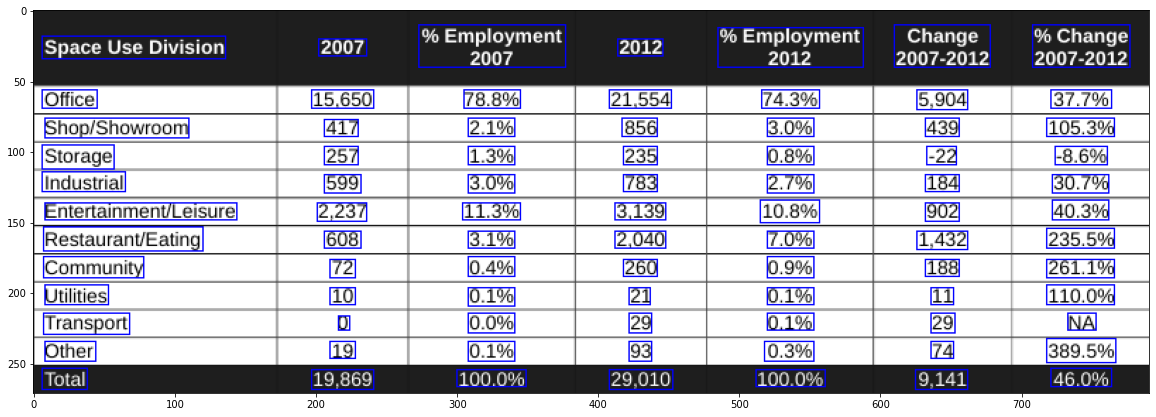

In [11]:
result3 = show_bounding_boxes(img, cleaned_bboxes)
plt.imshow(result3)

In [18]:
bboxes_converted = []
for bbox in cleaned_bboxes:
    bboxes_converted.append({'min_x': bbox[0], 
                             'min_y': bbox[1], 
                             'max_x': bbox[2], 
                             'max_y': bbox[3]})

## Read original XML file

In [14]:
total_cells, total_cells_non_empty, rows = count_cells(original_annotation_path)
max_columns = -1
max_visible_columns = -1
for row in rows:
    if len(row) > max_columns:
        max_columns = len(row)
    if row.count('tdy') > max_visible_columns:
        max_visible_columns = row.count('tdy')

print('Total number of cells:', total_cells)
print('Total number of non-empty cells:', total_cells_non_empty)
print('Number of rows:', len(rows))
print('Max number of columns:', max_columns)
print('Max number of visible columns:', max_visible_columns)

Total number of cells: 84
Total number of non-empty cells: 84
Number of rows: 12
Max number of columns: 7
Max number of visible columns: 7


## Set row and column index for each bbox

In [19]:
rows_idx = [-1] * img.shape[0]
row_idx = 0
for i in range(img.shape[0]):
    for bbox in cleaned_bboxes:
        if bbox[1] <= i <= bbox[3]:
            rows_idx[i] = row_idx
            break
    if 0 < i <= img.shape[0] and rows_idx[i-1] == row_idx != rows_idx[i]:
        row_idx += 1

bboxes_clone = bboxes_converted.copy()
for bbox in bboxes_clone:
    bbox['belong_to_row'] = rows_idx[bbox['min_y']]
    print(bbox)

{'min_x': 273, 'min_y': 10, 'max_x': 377, 'max_y': 40, 'belong_to_row': 0}
{'min_x': 610, 'min_y': 10, 'max_x': 678, 'max_y': 40, 'belong_to_row': 0}
{'min_x': 708, 'min_y': 10, 'max_x': 777, 'max_y': 40, 'belong_to_row': 0}
{'min_x': 485, 'min_y': 12, 'max_x': 588, 'max_y': 40, 'belong_to_row': 0}
{'min_x': 6, 'min_y': 18, 'max_x': 136, 'max_y': 34, 'belong_to_row': 0}
{'min_x': 202, 'min_y': 20, 'max_x': 236, 'max_y': 32, 'belong_to_row': 0}
{'min_x': 414, 'min_y': 20, 'max_x': 446, 'max_y': 32, 'belong_to_row': 0}
{'min_x': 6, 'min_y': 56, 'max_x': 45, 'max_y': 69, 'belong_to_row': 1}
{'min_x': 197, 'min_y': 56, 'max_x': 241, 'max_y': 69, 'belong_to_row': 1}
{'min_x': 305, 'min_y': 56, 'max_x': 345, 'max_y': 69, 'belong_to_row': 1}
{'min_x': 408, 'min_y': 56, 'max_x': 452, 'max_y': 69, 'belong_to_row': 1}
{'min_x': 516, 'min_y': 56, 'max_x': 557, 'max_y': 69, 'belong_to_row': 1}
{'min_x': 626, 'min_y': 56, 'max_x': 662, 'max_y': 70, 'belong_to_row': 1}
{'min_x': 721, 'min_y': 56, 'm

In [21]:
rows_2 = {}
for bbox in bboxes_clone:
    if rows_2.get(bbox['belong_to_row']) is None:
        rows_2[bbox['belong_to_row']] = []
    rows_2[bbox['belong_to_row']].append(bbox)
print(rows_2)

{0: [{'min_x': 273, 'min_y': 10, 'max_x': 377, 'max_y': 40, 'belong_to_row': 0}, {'min_x': 610, 'min_y': 10, 'max_x': 678, 'max_y': 40, 'belong_to_row': 0}, {'min_x': 708, 'min_y': 10, 'max_x': 777, 'max_y': 40, 'belong_to_row': 0}, {'min_x': 485, 'min_y': 12, 'max_x': 588, 'max_y': 40, 'belong_to_row': 0}, {'min_x': 6, 'min_y': 18, 'max_x': 136, 'max_y': 34, 'belong_to_row': 0}, {'min_x': 202, 'min_y': 20, 'max_x': 236, 'max_y': 32, 'belong_to_row': 0}, {'min_x': 414, 'min_y': 20, 'max_x': 446, 'max_y': 32, 'belong_to_row': 0}], 1: [{'min_x': 6, 'min_y': 56, 'max_x': 45, 'max_y': 69, 'belong_to_row': 1}, {'min_x': 197, 'min_y': 56, 'max_x': 241, 'max_y': 69, 'belong_to_row': 1}, {'min_x': 305, 'min_y': 56, 'max_x': 345, 'max_y': 69, 'belong_to_row': 1}, {'min_x': 408, 'min_y': 56, 'max_x': 452, 'max_y': 69, 'belong_to_row': 1}, {'min_x': 516, 'min_y': 56, 'max_x': 557, 'max_y': 69, 'belong_to_row': 1}, {'min_x': 626, 'min_y': 56, 'max_x': 662, 'max_y': 70, 'belong_to_row': 1}, {'min_x

In [22]:
sorted_rows = {}
max_detected_column = -1
for i, _row in rows_2.items():
    sorted_rows[i] = sorted(_row, key=lambda x: x['min_x'])
    for j in range(len(_row)):
        sorted_rows[i][j]['belong_to_column'] = j
        if j > max_detected_column:
            max_detected_column = j
sorted_rows

{0: [{'min_x': 6,
   'min_y': 18,
   'max_x': 136,
   'max_y': 34,
   'belong_to_row': 0,
   'belong_to_column': 0},
  {'min_x': 202,
   'min_y': 20,
   'max_x': 236,
   'max_y': 32,
   'belong_to_row': 0,
   'belong_to_column': 1},
  {'min_x': 273,
   'min_y': 10,
   'max_x': 377,
   'max_y': 40,
   'belong_to_row': 0,
   'belong_to_column': 2},
  {'min_x': 414,
   'min_y': 20,
   'max_x': 446,
   'max_y': 32,
   'belong_to_row': 0,
   'belong_to_column': 3},
  {'min_x': 485,
   'min_y': 12,
   'max_x': 588,
   'max_y': 40,
   'belong_to_row': 0,
   'belong_to_column': 4},
  {'min_x': 610,
   'min_y': 10,
   'max_x': 678,
   'max_y': 40,
   'belong_to_row': 0,
   'belong_to_column': 5},
  {'min_x': 708,
   'min_y': 10,
   'max_x': 777,
   'max_y': 40,
   'belong_to_row': 0,
   'belong_to_column': 6}],
 1: [{'min_x': 6,
   'min_y': 56,
   'max_x': 45,
   'max_y': 69,
   'belong_to_row': 1,
   'belong_to_column': 0},
  {'min_x': 197,
   'min_y': 56,
   'max_x': 241,
   'max_y': 69,
   '

In [23]:
rows

[['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy'],
 ['tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy', 'tdy']]

In [24]:
matched = True
if len(rows) == row_idx and max_visible_columns == max_detected_column + 1:
    rows_mapped = []
    for i in range(len(rows)):
        rows_temp = []
        visible_col_count = 0
        for j in range(len(rows[i])):
            if rows[i][j] == 'tdn':
                rows_temp.append({'tdn': {}})
            elif visible_col_count < len(sorted_rows[i]):
                rows_temp.append({'tdy': sorted_rows[i][visible_col_count]})
                visible_col_count += 1
            else:
                matched = False
                break
        if visible_col_count != rows[i].count('tdy') or not matched:
            matched = False
            break
        rows_mapped.append(rows_temp)
else:
    matched = False

In [25]:
matched

True